## Part 1

In [1]:
# import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim 
import folium
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

Using Beautiful soup to get the details from the table on Wikipedia

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5) AppleWebKit 537.36 (KHTML, like Gecko) Chrome",
           "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8"}
# 1. get the data using requests, store in 'response'
response = requests.get(url,headers=headers)
print(response)

<Response [200]>


In [3]:
soup = BeautifulSoup(response.text, 'html.parser')
wiki_table = soup.find('table',{'class':'wikitable sortable'})
wiki_table_rows = wiki_table.find_all('tr')

In [4]:
len(wiki_table_rows)

181

Defining the dataframe with three columns: PostalCode, Borough, and Neighborhood

In [5]:
# define the dataframe columns
column_names = ['PostalCode', 'Borough', 'Neighborhood'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
for data in wiki_table_rows:
    elem = data.find_all('td')
    if len(elem) > 0:
        postal = elem[0].text.strip()
        borough = elem[1].text.strip()
        neighborhood_name = elem[2].text.strip()
        
    #neighborhood_latlon = data['geometry']['coordinates']
    #neighborhood_lat = neighborhood_latlon[1]
    #neighborhood_lon = neighborhood_latlon[0]
    
# Ignore cells with a borough that is Not assigned.
        if(borough != 'Not assigned'):      
# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
            if(neighborhood_name == 'Not assigned'):
                neighborhood_name = borough
            neighborhoods = neighborhoods.append({'PostalCode': postal,
                                          'Borough': borough,
                                          'Neighborhood': neighborhood_name}, ignore_index=True)
    #                                      'Latitude': neighborhood_lat,
    #                                      'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [8]:
neighborhoods.shape

(103, 3)

## Part 2

#### Read location coordinates

I tried to use the geocoder library to fetch the coordinates but it was not working. So, I decided to use the Geospatial_Coordinates.csv file to get the coordinates.

In [9]:
coordinates = pd.read_csv('Geospatial_Coordinates.csv')
coordinates.head(5)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
neighborhoods = pd.merge(neighborhoods, coordinates, left_on='PostalCode', right_on='Postal Code').drop(['Postal Code'], axis = 1)
neighborhoods.head(5)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [11]:
print("The shape of the dataset is {}".format(neighborhoods.shape))

The shape of the dataset is (103, 5)


### Part 3

Define Foursquare Credentials and Version

In [12]:
CLIENT_ID = 'YKBMLD2MG4VKNU3WTETTSR1RUMIPPEIC42OJ10W0HK2Y1CHS' # your Foursquare ID
CLIENT_SECRET = 'PK3OR2LHB0VNVOCFNBS1P3YYFOJJTITWQAINUHROPPU0VHPN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YKBMLD2MG4VKNU3WTETTSR1RUMIPPEIC42OJ10W0HK2Y1CHS
CLIENT_SECRET:PK3OR2LHB0VNVOCFNBS1P3YYFOJJTITWQAINUHROPPU0VHPN


In [13]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Considering the data points where the Borough contains the word Toronto initially and then extending the analysis

In [14]:
toronto_neigh = neighborhoods[neighborhoods['Borough'].str.contains('Toronto')].reset_index(drop = True)

In [15]:
toronto_neigh.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [16]:
map_of_toronto = folium.Map(location = [latitude, longitude], zoom_start = 11)

for borough, neighborhood, latitude, longitude in zip(toronto_neigh['Borough'], 
                                                      toronto_neigh['Neighborhood'], 
                                                      toronto_neigh['Latitude'], 
                                                      toronto_neigh['Longitude']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'yellow',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_of_toronto)  
    
map_of_toronto

Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [17]:
toronto_neigh.loc[0, 'Neighborhood']

'Regent Park, Harbourfront'

In [18]:
neighborhood_latitude = toronto_neigh.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_neigh.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_neigh.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


Let's get the top 100 venues that are in Regent Park, Harbourfront within a radius of 500 meters.

In [19]:
# type your answer here
search_query = 'Regent Park, Harbourfront'
radius = 500
LIMIT=100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)
url


'https://api.foursquare.com/v2/venues/explore?client_id=YKBMLD2MG4VKNU3WTETTSR1RUMIPPEIC42OJ10W0HK2Y1CHS&client_secret=PK3OR2LHB0VNVOCFNBS1P3YYFOJJTITWQAINUHROPPU0VHPN&ll=43.6542599,-79.3606359&v=20180605&radius=500&limit=100'

In [20]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f9c13b2b8e5bb202e6baed7'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Corktown',
  'headerFullLocation': 'Corktown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 44,
  'suggestedBounds': {'ne': {'lat': 43.6587599045, 'lng': -79.3544279001486},
   'sw': {'lat': 43.6497598955, 'lng': -79.36684389985142}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54ea41ad498e9a11e9e13308',
       'name': 'Roselle Desserts',
       'location': {'address': '362 King St E',
        'crossStreet': 'Trinity St',
        'lat': 43.653446723052674,
        'lng': -79.3620167174383,
        'labeledLatLngs': [{'label': 'display',
 

In [21]:
# Extracting the information out of the result we got from the Foursquare API. 
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [22]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
3,Body Blitz Spa East,Spa,43.654735,-79.359874
4,Impact Kitchen,Restaurant,43.656369,-79.356980


In [23]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

44 venues were returned by Foursquare.


Get venues for all neighborhoods

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
# type your answer here
toronto_venues = getNearbyVenues(toronto_neigh.Neighborhood, toronto_neigh.Latitude, toronto_neigh.Longitude)
toronto_venues.head()

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [26]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,55,55,55,55,55,55
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,68,68,68,68,68,68
Christie,16,16,16,16,16,16
Church and Wellesley,75,75,75,75,75,75
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


In [27]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 237 uniques categories.


#### Neighborhood analysis

In [28]:
# one hot encoding
toronto_onehot  = pd.get_dummies(toronto_venues [['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot ['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
toronto_onehot.shape

(1624, 237)

Groupping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [30]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,Berczy Park,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.00
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.0625,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
4,Central Bay Street,0.014706,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.014706,0.000000,0.000000,0.014706,0.00
5,Christie,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
6,Church and Wellesley,0.026667,0.013333,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.013333,...,0.013333,0.013333,0.000000,0.000000,0.00,0.000000,0.000000,0.013333,0.000000,0.00
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.040000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.00
8,Davisville,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.030303,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
9,Davisville North,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00


In [31]:
toronto_grouped.shape

(39, 237)

Top 5 most common venues in Toronto

In [32]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
         venue  freq
0  Coffee Shop  0.09
1     Beer Bar  0.04
2       Bakery  0.04
3   Restaurant  0.04
4  Cheese Shop  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.13
1       Nightclub  0.09
2     Coffee Shop  0.09
3  Breakfast Spot  0.09
4             Gym  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0           Pizza Place  0.06
1      Recording Studio  0.06
2            Skate Park  0.06
3  Fast Food Restaurant  0.06
4                  Park  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                 venue  freq
0       Airport Lounge  0.12
1      Airport Service  0.12
2  Rental Car Location  0.06
3      Harbor / Marina  0.06
4     Sculpture Garden  0.06


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.18
1   

In [33]:
#unction to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Dataframe with the top 10 venues for each neighborhood.

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Bakery,Restaurant,Cheese Shop,Beer Bar,Cocktail Bar,Seafood Restaurant,Farmers Market,Breakfast Spot,Pharmacy
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Nightclub,Coffee Shop,Grocery Store,Burrito Place,Bakery,Intersection,Italian Restaurant,Restaurant
2,"Business reply mail Processing Centre, South C...",Park,Pizza Place,Skate Park,Brewery,Burrito Place,Farmers Market,Fast Food Restaurant,Restaurant,Butcher,Recording Studio
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Sculpture Garden,Boutique,Plane,Rental Car Location,Coffee Shop,Boat or Ferry,Harbor / Marina,Bar
4,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Burger Joint,Department Store,Bubble Tea Shop,Thai Restaurant,Japanese Restaurant,Salad Place


### Cluster Neighborhoods

In [36]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

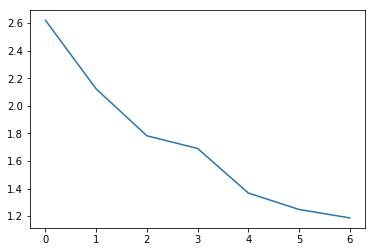

In [37]:
# Elbow curve/Sum of squared distances(SSD)
ssd =  []
range_n_clusters = [2,3,4,5,6,7,8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=500, init ='k-means++')
    kmeans.fit(toronto_grouped_clustering)
    
    ssd.append(kmeans.inertia_)
    
#Plot the SSDs for each n_cluster
#ssd

plt.plot(ssd)

Setting number of clusters to 4 as we see a elbow

In [38]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [39]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_neigh

# merge toronto_grouped with toronto to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Park,Pub,Bakery,Café,Theater,Breakfast Spot,Brewery,Spa,Beer Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Yoga Studio,Café,Smoothie Shop,Beer Bar,Italian Restaurant,Sandwich Place,Restaurant,Distribution Center,Diner
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Pizza Place,Ramen Restaurant,Bookstore,Middle Eastern Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Cocktail Bar,Restaurant,Gastropub,Beer Bar,American Restaurant,Lingerie Store,Hotel,Cosmetics Shop
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Pub,Trail,Health Food Store,Women's Store,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant


In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Examining Clusters

Cluster 0

In [41]:
res = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print("For cluster 0, the distribution of venues is as:\n{}".format(res['1st Most Common Venue'].value_counts()))
res

For cluster 0, the distribution of venues is as:
Trail    1
Pub      1
Name: 1st Most Common Venue, dtype: int64


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,East Toronto,0,Pub,Trail,Health Food Store,Women's Store,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
29,Central Toronto,0,Trail,Playground,Women's Store,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


Cluster 1

In [42]:
res = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print("For cluster 1, the distribution of venues is as:\n{}".format(res['1st Most Common Venue'].value_counts()))
res

For cluster 1, the distribution of venues is as:
Park    3
Name: 1st Most Common Venue, dtype: int64


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,1,Park,Swim School,Bus Line,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
21,Central Toronto,1,Park,Sushi Restaurant,Jewelry Store,Trail,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
33,Downtown Toronto,1,Park,Trail,Playground,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


Cluster 2

In [43]:
res = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print("For cluster 2, the distribution of venues is as:\n{}".format(res['1st Most Common Venue'].value_counts()))
res

For cluster 2, the distribution of venues is as:
Coffee Shop           17
Park                   3
Bar                    2
Café                   2
Sandwich Place         2
Airport Lounge         1
Gift Shop              1
Clothing Store         1
Grocery Store          1
Greek Restaurant       1
Mexican Restaurant     1
Pharmacy               1
Name: 1st Most Common Venue, dtype: int64


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,2,Coffee Shop,Park,Pub,Bakery,Café,Theater,Breakfast Spot,Brewery,Spa,Beer Store
1,Downtown Toronto,2,Coffee Shop,Yoga Studio,Café,Smoothie Shop,Beer Bar,Italian Restaurant,Sandwich Place,Restaurant,Distribution Center,Diner
2,Downtown Toronto,2,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Pizza Place,Ramen Restaurant,Bookstore,Middle Eastern Restaurant
3,Downtown Toronto,2,Coffee Shop,Café,Cocktail Bar,Restaurant,Gastropub,Beer Bar,American Restaurant,Lingerie Store,Hotel,Cosmetics Shop
5,Downtown Toronto,2,Coffee Shop,Bakery,Restaurant,Cheese Shop,Beer Bar,Cocktail Bar,Seafood Restaurant,Farmers Market,Breakfast Spot,Pharmacy
6,Downtown Toronto,2,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Burger Joint,Department Store,Bubble Tea Shop,Thai Restaurant,Japanese Restaurant,Salad Place
7,Downtown Toronto,2,Grocery Store,Café,Park,Baby Store,Nightclub,Athletics & Sports,Restaurant,Coffee Shop,Candy Store,Italian Restaurant
8,Downtown Toronto,2,Coffee Shop,Café,Restaurant,Hotel,Bar,Gym,Clothing Store,Thai Restaurant,Juice Bar,Concert Hall
9,West Toronto,2,Pharmacy,Bakery,Grocery Store,Supermarket,Middle Eastern Restaurant,Music Venue,Café,Brewery,Bar,Bank
10,Downtown Toronto,2,Coffee Shop,Aquarium,Hotel,Café,Restaurant,Fried Chicken Joint,Scenic Lookout,Brewery,Music Venue,Park


Cluster 3

In [44]:
res = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print("For cluster 3 the distribution of venues is as:\n{}".format(res['1st Most Common Venue'].value_counts()))
res

For cluster 3 the distribution of venues is as:
Music Venue    1
Name: 1st Most Common Venue, dtype: int64


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,3,Music Venue,Garden,Women's Store,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


We see the the four clusters are created. The Cluster 0,1,2,3 has Trail and Pub, Park, Coffee shop, Music Venue as the first most common venue.